Запуск обучения моделей с параметрами как в конфиге TabDDPM на данных, где на категориальных признаках используется OHE. Этот датасет подается TabDDPM как полностью числовой (число категориальных переменных равно 0). Внутри обучения модели на каждом шаге цикла обучения при получении батча происходит добавление шума $N(0, \sigma)$, где $\sigma$ как раз меняется от модели к модели. У первых нескольких моделей она константная, у остальных моделей есть некое ее изменение (постепенное уменьшение). 

Нормализация данных: quantile для числовых метрик и Standart Scaler для OHE

Добавление шума: ко всем

Число эпох обучения: 200'000

In [2]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm_ON_QnSC.tabddpm_ON_QnSC import *

from tqdm.notebook import tqdm

### Cкачиваем и преобразовываем данные

In [4]:
dataname = 'adult_ON_QnSC_200k'
model_name = 'tabddpm_ON_QnSC'
model_name_postfix = '_200k'
dataname_initial = 'adult'

In [4]:
import shutil
try:
    shutil.rmtree(f'./data/{dataname}')
except Exception as e:
    print(e)

with open(f'data/Info/{dataname_initial}.json', 'r') as f:
    info = json.load(f)

info['name'] = dataname
info['data_path'] = f'data/{dataname}/{dataname}.data'
info['test_path'] = f'data/{dataname}/{dataname}.test'
info['task_type'] = 'regression'

with open(f'data/Info/{dataname}.json', 'w', encoding='utf-8') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)

download_dataset('adult', dataname)

import os
for file in tqdm(os.listdir(f'./data/{dataname}')):
    old_file = os.path.join(f'./data/{dataname}', file)
    new_file = os.path.join(f'./data/{dataname}', file.replace(dataname_initial, dataname))
    os.rename(old_file, new_file)
    
normalizers = categorial_to_OHE(dataname, do_quantile_and_standart_scale=True)
process_data(dataname)
postprocess_OHE(dataname, dataname_initial)

Start processing dataset adult from UCI.
Finish downloading dataset from https://archive.ics.uci.edu/static/public/2/adult.zip, data has been saved to data/adult_ON_QnSC_200k.
Finish unzipping adult.


  0%|          | 0/6 [00:00<?, ?it/s]

{'cat_col_idx': [],
 'cat_col_idx_initial': [6, 7, 8, 9, 10, 11, 12, 13],
 'column_info': {'0': 'float',
                 '10': 'float',
                 '11': 'float',
                 '12': 'float',
                 '13_ ?_after_OHE': 'float',
                 '13_ Cambodia_after_OHE': 'float',
                 '13_ Canada_after_OHE': 'float',
                 '13_ China_after_OHE': 'float',
                 '13_ Columbia_after_OHE': 'float',
                 '13_ Cuba_after_OHE': 'float',
                 '13_ Dominican-Republic_after_OHE': 'float',
                 '13_ Ecuador_after_OHE': 'float',
                 '13_ El-Salvador_after_OHE': 'float',
                 '13_ England_after_OHE': 'float',
                 '13_ France_after_OHE': 'float',
                 '13_ Germany_after_OHE': 'float',
                 '13_ Greece_after_OHE': 'float',
                 '13_ Guatemala_after_OHE': 'float',
                 '13_ Haiti_after_OHE': 'float',
                 '13_ Holand-Ne

In [5]:
from pickle import dump, load

if globals().get('normalizers'):
    dump(normalizers['num_normalizer'], open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'wb'))
    dump(normalizers['cat_normalizer'], open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'wb'))
    
    with open(f'data/{dataname}/normalizers.json', 'w', encoding='utf-8') as f:
        json.dump({
                        'len_num_prev':normalizers['len_num_prev'],
                        'len_cat_prev':normalizers['len_cat_prev'],
                        'len_target_prev':normalizers['len_target_prev'],
                    }, f, ensure_ascii=False, indent=4)
    print(f"normalizers saved to `data/{dataname}` folder")
else:
    with open(f'data/{dataname}/normalizers.json', 'r') as f:
        normalizers = json.load(f)
    normalizers['num_normalizer'] = load(open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'rb'))
    normalizers['cat_normalizer'] = load(open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'rb'))
    print(f"normalizers received from `data/{dataname}` folder")

normalizers saved to `data/adult_ON_QnSC_200k` folder


### Подготовка

In [6]:
with open(f'data/Info/{dataname}.json', 'r') as f:
    info = json.load(f)

In [7]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [8]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('save_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('sample_save_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")

Device: cuda


### Train

In [9]:
CONFIG.add_arg('mode', 'train')
CONFIG.add_arg('num_noise', info['prev_cat_num'])

CONFIG.add_arg('info_path', None)
                   # f"data/{CONFIG.get_arg('dataname')}/info.json")
CONFIG.add_arg('real_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path', None)
                   # f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")

In [10]:
CONFIG.add_arg('dataname', None)
CONFIG.add_arg('method', None)
CONFIG.add_arg('device', None)

In [11]:
CONFIG.get_all_args()

{'dataname': None,
 'method': None,
 'device': None,
 'mode': 'train',
 'train': 1,
 'sample_save_path': None,
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 103,
 'real_path': None,
 'test_path': None,
 'info_path': None,
 'save_path': None}

In [ ]:
model_save_path_hist = []
for sigma in [0.01, 0.25, 0]:
    try:
        model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
        model_save_path_hist.append(model_save_path)
    
        tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=np.ones(200000) * sigma,
                                             dataname=dataname, device=device)
        tabddpm_noise_ohe.train()
    
        loss = pd.read_csv(f'{model_save_path}/loss.csv')
        start_step = 0
        for l in loss.columns[1:]:
          plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
        plt.legend()
        plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
        plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
                  np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])  
        
        plt.savefig(f'{model_save_path}/loss_image.png')
        
        plt.show()
        
        for file in tqdm(os.listdir(model_save_path)):
            if ('0000' in file) or ('model_ema.pt' in file):
                os.remove(os.path.join(model_save_path, file))
    except Exception as e:
        with open('error.txt', "a") as text_file:
             text_file.write(f"ERROR: {str(e)}")

In [5]:
sigmas_list = []

# linear from 0.25 to 0.01
sigmas_list.append(np.linspace(0.25, 0.01, 200000))

# cosine from 0.5 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, 200000)) + 1) * 0.5 / 2)

# linear from 0.25 to 0.01 x 100'000 steps + 0.01 x 100'000 
sigmas_list.append(np.concatenate([np.linspace(0.25, 0.01, 100000), 
                    np.ones(100000)  * 0.01,
                   ]))

idx = [5, 6, 10]

In [33]:
for i, sigmas in zip(idx, sigmas_list):
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    model_save_path_hist.append(model_save_path)
    
    tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=sigmas,
                                         dataname=dataname, device=device)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()

    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

In [6]:
model_save_path_hist = []
for sigma in [0.01, 0.25, 0]:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)

for i in idx:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    model_save_path_hist.append(model_save_path)

In [7]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(len(model_save_path_hist))

/tmp/ipykernel_24168/248767542.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


0it [00:00, ?it/s]

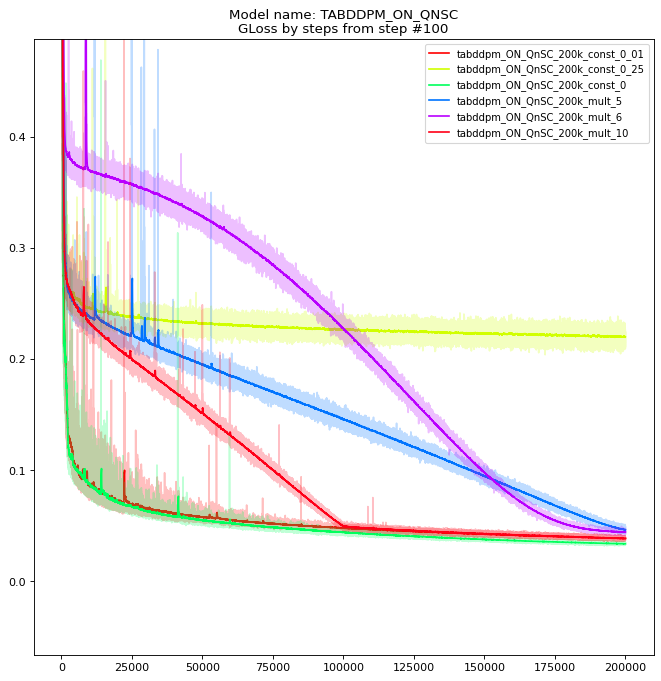

In [8]:
plt.figure(figsize=(10, 10), dpi=80)

max_v, min_v = -np.inf, np.inf
window = 250

for i, model_save_path in tqdm(enumerate(model_save_path_hist)):
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], alpha=0.25, color=cmap(i))

    smoothed = np.convolve(loss['gloss'][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=model_save_path.split('/')[-1], color=cmap(i))

    max_v = np.max([np.quantile(loss['gloss'][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss['gloss'][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1])    
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nGLoss by steps from step #{start_step}")

plt.savefig(f'total_loss/{dataname_initial}/total_loss_image_{model_name}{model_name_postfix}.png')

plt.show()

In [38]:
f'total_loss/{dataname}_total_loss_image_{model_name}{model_name_postfix}.png'

'total_loss/adult_ON_QnSC_200k_total_loss_image_tabddpm_ON_QnSC_200k.png'

In [ ]:
for model_save_path in model_save_path_hist:
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], label=model_save_path.split('/')[-1])

    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])    
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    plt.show()

In [43]:
model_save_path_hist

['./models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_const_0_01',
 './models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_const_0_25',
 './models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_const_0',
 './models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_mult_5',
 './models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_mult_6',
 './models/tabddpm_ON_QnSC/ckpt/adult/tabddpm_ON_QnSC_200k_mult_10']

/tmp/ipykernel_87075/248767542.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


0it [00:00, ?it/s]

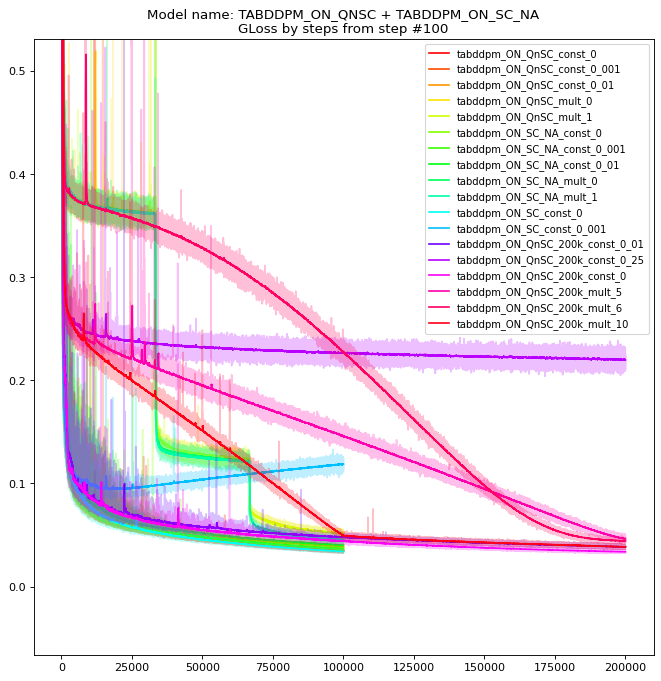

In [46]:
last_loss = []
model_save_path_hist = []

for model_short in ['tabddpm_ON_QnSC', 'tabddpm_ON_SC_NA', 'tabddpm_ON_SC']:
    for sigma in [0, 0.001, 0.01]:
        model_save_path=f"./models/{model_short}/ckpt/{model_short}_const_{str(sigma).replace('.', '_')}"
        model_save_path_hist.append(model_save_path)
    
    for i, sigmas in enumerate([5,9]):
        model_save_path=f"./models/{model_short}/ckpt/{model_short}_mult_{i}"
        model_save_path_hist.append(model_save_path)

for model_short in ['tabddpm_ON_QnSC']:
    for sigma in [0.01, 0.25, 0]:
        model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
        model_save_path_hist.append(model_save_path)
    
    for i in [5,6, 10]:
        model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
        model_save_path_hist.append(model_save_path)

cmap = get_cmap(len(model_save_path_hist))

plt.figure(figsize=(10, 10), dpi=80)

max_v, min_v = -np.inf, np.inf
window = 250

for i, model_save_path in tqdm(enumerate(model_save_path_hist)):
    try:
        loss = pd.read_csv(f'{model_save_path}/loss.csv')
        last_loss.append({
                            'model_name':model_save_path.split('/')[-1],
                            'loss':loss['loss'][-1000:].mean()
        })
        
        start_step = 100
        plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], alpha=0.25, color=cmap(i))
    
        smoothed = np.convolve(loss['gloss'][start_step:], np.ones(window)/window, 'valid')  
        plt.plot(loss['step'][start_step+window-1:], smoothed, label=model_save_path.split('/')[-1], color=cmap(i))
    
        max_v = np.max([np.quantile(loss['gloss'][start_step:], 0.99), max_v])
        min_v = np.min([np.quantile(loss['gloss'][start_step:], 0.01), min_v])
    except Exception as e:
        pass

plt.ylim([min_v-0.1, max_v+0.1])    
plt.legend()
plt.title(f"Model name: {'tabddpm_ON_QnSC'.upper()} + {'tabddpm_ON_SC_NA'.upper()}\nGLoss by steps from step #{start_step}")

# plt.savefig(f'total_loss/total_loss_image_{model_name}.png')

plt.show()

In [47]:
pd.DataFrame.from_dict(last_loss).round(4).sort_values('loss')

,model_name,loss
14,tabddpm_ON_QnSC_200k_const_0,0.0337
10,tabddpm_ON_SC_const_0,0.0340
0,tabddpm_ON_QnSC_const_0,0.0345
1,tabddpm_ON_QnSC_const_0_001,0.0349
6,tabddpm_ON_SC_NA_const_0_001,0.0366
5,tabddpm_ON_SC_NA_const_0,0.0370
12,tabddpm_ON_QnSC_200k_const_0_01,0.0385
17,tabddpm_ON_QnSC_200k_mult_10,0.0385
2,tabddpm_ON_QnSC_const_0_01,0.0389
7,tabddpm_ON_SC_NA_const_0_01,0.0403
